# Static Form-Factor

Import some libraries and modules.

In [132]:
import numpy as np
import utils
from scipy import integrate

Functions to calculate static form factor, following ref: [Parallel Spinodal Decomposition](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.37.5355&rep=rep1&type=pdf).

In [88]:
# calculates form factor S where u is complex-valued.
def formfactor(u,dim):
    u = np.fft.fftn(u)
    u = np.fft.fftshift(u)
    return u*np.conj(u)
    
# average over a given number of runs.
def averaging(Nx,L,dt,it,eps,sigma,m,seeds,lv=None,imgDir=None,tag=None,dim=2,path=None):
    if dim==1:
        T = np.zeros(Nx, dtype='complex128')
    if dim==2:
        T = np.zeros((Nx,Nx), dtype='complex128')
        
    j = 0 
    for seed in seeds:
        if path == None:
            folder = utils.getPath(Nx,L,dt,it,eps,sigma,m,seed,lv,imgDir,tag)
            pathFull = folder + '/it='+str(it)+'.txt'
        else:
            pathFull = path + 'uArray-sigma='+str(sigma)+',it='+str(it)+',seed='+str(seed)+'.txt'
            
        uArr = np.loadtxt(pathFull)
        S = formfactor(uArr,dim)
        T = T + S
        j += 1
    return T / j
    
# normalise an array.
def normalisation(T):
    return T / np.sum(T)
    
# circular averaging based on freq.
def circularAvg(V,kValues,kGrid):
    Sk = np.zeros(len(kValues), dtype='complex128')

    j = 0
    for value in kValues:
        # the positions on the kGrid where the value is a given k value.
        coordinates = np.where(kGrid == value)
        Sk[j] = np.mean(V[coordinates])
        j += 1
    return Sk
        
# calculate scaling factor
def scaleFactor(Sk,kValues):
    posKs = np.where(kValues >= 0)
    return integrate.simps(kValues[posKs]*Sk[posKs],kValues[posKs])/integrate.simps(Sk[posKs],kValues[posKs])

Code for the form-factor analysis of the uArrays (2D Strang-Splitting).

In [106]:
seeds = [555,4379,7626,12883,17384,23057,24800,33688,40385,41277]
sigmas = [0.0001, 0.0005, 0.0010, 0.0015, 0.0020, 0.0025, 0.0030]

it = 200000
it += 1
Nx = 100
L = 2.*np.pi
dt = 0.002
eps = 0.06
m = 0.33

sFactors = np.zeros(len(sigmas))
kGrid = utils.wavenumber(Nx)[0]
kGrid = np.fft.fftshift(kGrid)
kValues = np.unique(kGrid)
path = 'uArrays/'
    
j = 0
for sigma in sigmas:
    T = np.zeros((Nx,Nx), dtype='complex128')
    T = averaging(Nx,L,dt,it,eps,sigma,m,seeds,path=path)
    V = normalisation(T)

    Sk = circularAvg(V,kValues,kGrid)
    sFactors[j] = np.real(scaleFactor(Sk,kValues))
    j += 1

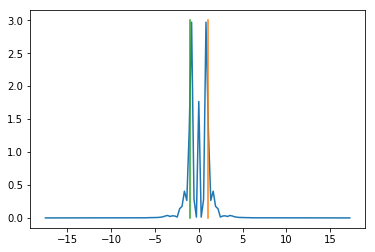

In [126]:
sFactor = sFactors[0]
yaxis = sFactor**2 * Sk
xaxis = kValues/sFactor
plt.plot(xaxis,yaxis)

plt.plot((1., 1.), (0., 3.), '')
plt.plot((-1., -1.), (0., 3.), '')
plt.show()

log(sFactors): [-0.29712254 -0.29722982 -0.29735206 -0.29747549 -0.2975953  -0.29771241
 -0.2978275 ]
slope: -0.24246, intercept: -0.29711, std. err.: 0.00222


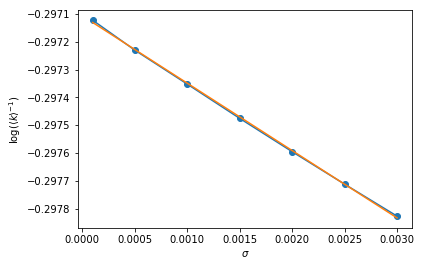

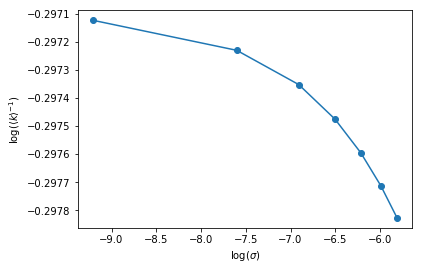

In [118]:
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

sigmas = np.array(sigmas)

sFactorsLog = np.log(1./sFactors)
sigmasLog = np.log(sigmas)
print("log(sFactors): %s" %(str(sFactorsLog)))

slope, intercept, r_value, p_value, std_err = stats.linregress(sigmas,sFactorsLog)
line = slope*sigmas+intercept
print("slope: %.5f, intercept: %.5f, std. err.: %.5f" %(slope,intercept,std_err))

fig0 = plt.figure()
plt.plot(sigmas,sFactorsLog,'o-')
plt.plot(sigmas,line)
plt.xlabel(r'$\sigma$')
plt.ylabel(r'log($\langle k \rangle ^{-1}$)')
plt.show()

fig1 = plt.figure()
plt.plot(sigmasLog,sFactorsLog,'o-')
plt.xlabel(r'log($\sigma$)')
plt.ylabel(r'log($\langle k \rangle ^{-1}$)')
plt.show()

Code for the form-factor analysis of "imgs/folder" (1D ETDRK4).

In [119]:
seeds_Set1 = [555,4379,7626,12883,17384,23057,24800,33688,40385,41277]
seeds_Set2 = [3076,17145,27193,32927,47329,62877,75313,81602,91403,100000]
seeds = seeds_Set1 + seeds_Set2

sigmas = [0.0001, 0.0005, 0.0010, 0.0015, 0.0020, 0.0025, 0.0030]

it = 400000
Nx = 128
Lx = 2.*np.pi
dt = 0.001
eps = 0.06
m = 0.33
lv = 2000

imgDir = 'imgs/'
tag = ',etdrk4_1D'

sFactors = np.zeros(len(sigmas))
kGrid = utils.wavenumber(Nx,dim=1)[0]
kGrid = np.fft.fftshift(kGrid)
kValues = np.unique(kGrid)

j = 0
for sigma in sigmas:
    T = averaging(Nx,Lx,dt,it,eps,sigma,m,seeds,lv,imgDir,tag,dim=1)
    V = normalisation(T)
    
    Sk = circularAvg(V,kValues,kGrid)
    sFactors[j] = np.real(scaleFactor(Sk,kValues))
    j += 1

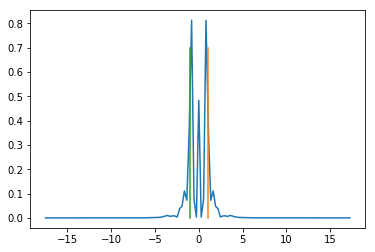

In [122]:
import matplotlib.pyplot as plt
%matplotlib inline

sFactor = sFactors[0]
yaxis = sFactor * Sk
xaxis = kValues/sFactor
plt.plot(xaxis,yaxis)

plt.plot((1., 1.), (0., 0.7), '')
plt.plot((-1., -1.), (0., 0.7), '')
plt.show()

log(sFactors): [-1.29624897 -1.29653117 -1.29667999 -1.2967543  -1.29682196 -1.29698418
 -1.29715764]
slope: -0.27397, intercept: -1.29632, std. err.: 0.02771


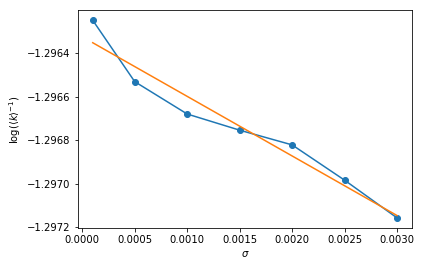

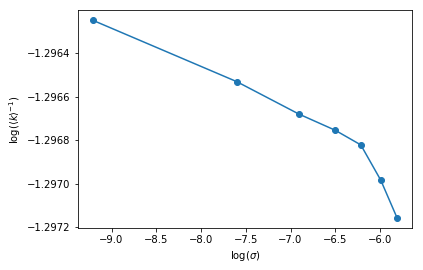

In [131]:
sigmas = np.array(sigmas)

sFactorsLog = np.log(1./sFactors)
sigmasLog = np.log(sigmas)
print("log(sFactors): %s" %(str(sFactorsLog)))

slope, intercept, r_value, p_value, std_err = stats.linregress(sigmas,sFactorsLog)
line = slope*sigmas+intercept
print("slope: %.5f, intercept: %.5f, std. err.: %.5f" %(slope,intercept,std_err))

fig0 = plt.figure()
plt.plot(sigmas,sFactorsLog,'o-')
plt.plot(sigmas,line)
plt.xlabel(r'$\sigma$')
plt.ylabel(r'log($\langle k \rangle ^{-1}$)')
plt.show()

fig1 = plt.figure()
plt.plot(sigmasLog,sFactorsLog,'o-')
plt.xlabel(r'log($\sigma$)')
plt.ylabel(r'log($\langle k \rangle ^{-1}$)')
plt.show()